<h3>Imports

In [149]:
# Imports de modelos de classificadores
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Import de divisor de dados para classificadores
from sklearn.model_selection import train_test_split

# Import de biblioteca de gerenciamento de arquivos
import pandas as pd

# Import de bibliotecas matemáticas
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, make_scorer, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, cross_validate
import numpy as np

# Import de biblioteca para ROC
from sklearn.preprocessing import label_binarize

<h3>Função Importação Data Frame

In [150]:
# # Função de Data Frames para execução dos algoritmos de machine learning
def importacaoDataFrame(tipo, autor):

    # Definição de caminho de arquivo para autores da execução
    if(autor == 'Hugo'):
        caminho = 'C:/Users/Hugo/'
    elif(autor == 'Arthur'):
        caminho = '/Users/arthurhenrique/Documentos/pessoal/faculdade/documentos/tcc/repository/'

    # Verificação de tipo de banco de dados a ser utilizado
    if(tipo == 'normal'):
        # Data Frame de Base apenas balanceada
        df = pd.read_csv(f'{caminho}machine-learning-water-quality/notebook/output/amostra_por_classificador.csv')

    elif(tipo == 'adasyn'):
        # Data Frame com oversampling ADASYN
        df = pd.read_csv(f'{caminho}machine-learning-water-quality/notebook/output/adasyn.csv')

    elif(tipo == 'smote'):
        # Data Frame com oversampling SMOTE
        df = pd.read_csv(f'{caminho}machine-learning-water-quality/notebook/output/smote.csv')
    else:
        print('null')
        return

    # Retorno do Data Frame a ser utilizado
    return df

<h3>Função de divisão dos dados

In [151]:
# # Função para divisão de dados de treino e teste e suas proporções
def divisaoDados(dataFrame):
    
    # A variável X determina o conjunto de atributos sem o rótulo
    X = dataFrame.drop('WQI', axis=1)

    # O Y são os rótulos contendo a classificação do WQI
    y = dataFrame['WQI']

    # Divisão entre X e Y de treinamento e teste com parametro de proporção entre os mesmos
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Retorno da divisão de dados teste e treinamento e suas proporções
    return X_train, X_test, y_train, y_test, X, y

<h3>Função para treinamento e teste do modelo

In [152]:
# # Função para treinamento, teste e escolha de modelos de machine learning
def modelTraining(tipo, X_train, X_test, y_train, y_test, X, y):
    
    # Verificação do tipo do modelo   
    if(tipo == 'Decision Tree'):
        
        #ccpAlpha(X, y, X_train, y_train)

        # Modelo de Árvore de Decisão e seus parâmetros
        model = DecisionTreeClassifier(criterion="gini", ccp_alpha= 0.003443637341942427, splitter='best', max_depth=None, max_leaf_nodes=None, random_state=42, class_weight=None)

    elif(tipo == 'Random Forest'):

        alpha = ccpAlphaForest(X, y, X_train, y_train)

        # Modelo de Random Forest e seus parâmetros0
        model = RandomForestClassifier(criterion="gini", ccp_alpha=0.0018444094977381712, max_depth=None, max_leaf_nodes=None, random_state=42, class_weight=None, n_estimators=100)
    
    elif(tipo == 'Logistic Regression'):

        # Modelo de Regressão Linear
        model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
    
    elif(tipo == 'SVM'):

        # Modelo de Support Vector Machine
        model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True)
    else:
        
        print('null')
        return

    # Treinamento do modelo
    model.fit(X_train, y_train)

    # Testes de predição do modelo
    y_pred = model.predict(X_test)

    # Retorno do modelo treinado e testado
    return model, X_train, X_test, y_train, y_test, y_pred, X, y

<h3>Função para encontrar o melhor ccp_alpha

In [153]:
def ccpAlpha(X, y, X_train, y_train):
    
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X, y)

    path = model.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas = path.ccp_alphas
    impurities = path.impurities

    plt.figure(figsize=(10, 6))
    plt.plot(ccp_alphas, impurities, marker="o", drawstyle="steps-post")
    plt.xlabel("Effective alpha (ccp_alpha)")
    plt.ylabel("Total Impurity of Leaves")
    plt.title("Impurity of leaves vs Effective Alpha for Pruning")
    plt.grid(True)
    plt.show()

    # Armazenar as médias de validação cruzada para cada valor de ccp_alpha
    alpha_scores = []

    # Loop através de cada valor de ccp_alpha e avalie o desempenho
    for ccp_alpha in ccp_alphas:
        model = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
        scores = cross_val_score(model, X, y, cv=30)  # Validação cruzada
        alpha_scores.append(scores.mean())
    # Encontre o melhor valor de ccp_alpha
    best_alpha = ccp_alphas[alpha_scores.index(max(alpha_scores))]
    print(f"BEST ALPHA: {best_alpha}")

    return best_alpha

<h3>Função para visualização de relatórios

In [155]:
# # Função de configuração das obtenções de métricas de desempenho e visualização
def visualizacaoRelatorios(model, tipoModelo):

    metricas = {
        'precision': make_scorer(precision_score, average=None),
        'recall': make_scorer(recall_score, average=None),
        'f1': make_scorer(f1_score, average=None),
        'roc_auc': make_scorer(roc_auc_score, average=None, multi_class='ovr')
    }

    scores = cross_validate(model[0], model[6], model[7], scoring=metricas, cv =30)

    precisaoMedia = np.mean(scores['test_precision'], axis=0)
    recallMedio = np.mean(scores['test_recall'], axis=0)
    f1Medio = np.mean(scores['test_f1'], axis=0)
    rocAUCMedio = np.mean(scores['test_roc_auc'], axis=0)

    print("Precisão: ", scores['test_precision'])
    print("Recall Média: ", precisaoMedia)
    print("Recall: ", scores['test_recall'])
    print("Recall Médio: ", recallMedio)
    print("F1: ", scores['test_f1'])
    print("F1 Médio: ", f1Medio)
    print("AUC: ", scores['test_roc_auc'])
    print("AUC Médio: ", rocAUCMedio)

    # Checagem para relatório de importância
    if(tipoModelo == 'Decision Tree' or 'Random Forest'):

        # Importância dos atributos para resultados obtidos
        feature_importances = model[0].feature_importances_
        sns.barplot(x=feature_importances, y=model[1].columns)
        plt.title("Feature Importance")
        plt.show()
    
    # Visualização Matriz de Confusão
    confusionMatrix = confusion_matrix(model[4], model[5])
    sns.heatmap(confusionMatrix, annot=True, fmt="d", cmap="Blues")

    # Visualização ROC
    y_test_bin = label_binarize(model[4], classes=[1, 2, 3, 4])
    n_classes = y_test_bin.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_pred_proba = model[0].predict_proba(model[2])
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'green', 'red', 'orange']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'ROC curve for class {i+1} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Classes 1 to 4')
    plt.legend(loc="lower right")
    plt.show()

<h3>Função de execução e relatório

In [157]:
# # Função de integração geral de funções prévias e relatórios respectivos
def machineLearning(tipoDataFrame, tipoModelo, autor):

    # Chamada de funções para importação e divisão do data frame
    dfDividido = divisaoDados(importacaoDataFrame(tipoDataFrame, autor))

    # Chamada de função de treinamento e teste
    model = modelTraining(tipoModelo, dfDividido[0], dfDividido[1], dfDividido[2], dfDividido[3], dfDividido[4], dfDividido[5])

    # Chamada de função com relatórios relacionados
    visualizacaoRelatorios(model, tipoModelo)

    crossValidation(model[0], dfDividido[4], dfDividido[5])

<h2>Execução de métricas

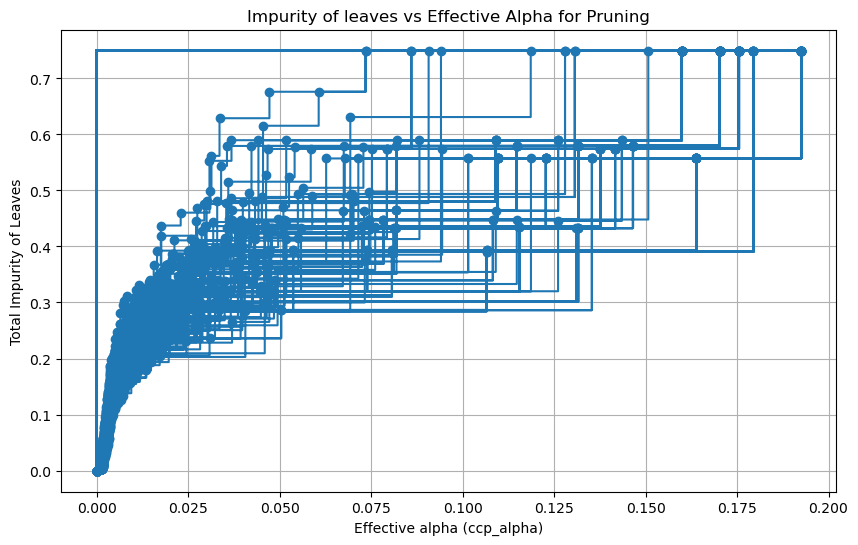

KeyboardInterrupt: 

In [158]:
machineLearning('normal', 'Decision', 'Hugo')